In [8]:
# ===================== Imports =====================
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    BertTokenizer,
    BertModel,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer
)
from adapters import AutoAdapterModel, AdapterConfig
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import warnings
warnings.filterwarnings("ignore")

# ===================== Global Variables =====================
# Mapping label indices to emotion names
EMOTION_LABELS = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}


# ===================== Utility Functions =====================

def get_device():
    """
    Detects and returns the best available device (MPS or CPU).

    Returns:
        torch.device: Device to run computations on.
    """
    return torch.device("mps" if torch.backends.mps.is_available() else "cpu")


def load_emotion_dataset():
    """
    Loads and tokenizes the SetFit/emotion dataset using BERT tokenizer.

    Returns:
        tuple:
            - DatasetDict: Tokenized dataset with train/val/test splits.
            - BertTokenizer: Tokenizer used for encoding.
    """
    dataset = load_dataset("SetFit/emotion")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def tokenize(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

    encoded = dataset.map(tokenize, batched=True)
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return encoded, tokenizer


def compute_metrics(eval_pred):
    """
    Computes classification metrics from predictions and true labels.

    Args:
        eval_pred (tuple): A tuple of (logits, labels).

    Returns:
        dict: accuracy, f1, recall, precision.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted")
    }


def get_training_args(output_dir, use_safetensors=True):
    """
    Returns Hugging Face TrainingArguments configuration.

    Args:
        output_dir (str): Directory to save logs and checkpoints.
        use_safetensors (bool): Whether to save in safetensors format.

    Returns:
        TrainingArguments: Training configuration object.
    """
    return TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir=output_dir + "/logs",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none",
        save_safetensors=use_safetensors
    )


def train_and_evaluate(model, model_name, dataset, tokenizer, use_safetensors=True):
    """
    Trains and evaluates the model using Hugging Face Trainer API.

    Args:
        model (nn.Module): The model to train.
        model_name (str): Name for results directory.
        dataset (DatasetDict): Tokenized train/val/test splits.
        tokenizer (BertTokenizer): Tokenizer used for preprocessing.
        use_safetensors (bool): Save models using SafeTensors format.

    Returns:
        dict: Training logs, metrics, and evaluation report.
    """
    args = get_training_args(f"./results_{model_name}", use_safetensors)

    trainer = Trainer(
        model=model.to(get_device()),
        args=args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    results = trainer.predict(dataset["test"])
    y_pred = np.argmax(results.predictions, axis=1)
    y_true = results.label_ids

    report = classification_report(y_true, y_pred, digits=4)
    cm = confusion_matrix(y_true, y_pred)

    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for log in trainer.state.log_history:
        if "loss" in log:
            train_loss.append(log["loss"])
        if "eval_loss" in log:
            val_loss.append(log["eval_loss"])
        if "eval_accuracy" in log:
            val_acc.append(log["eval_accuracy"])

    train_acc = val_acc  # Train accuracy not logged, duplicating val_acc

    test_metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted")
    }

    return {
        "log_history": trainer.state.log_history,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "report": report,
        "cm": cm,
        "test_metrics": test_metrics
    }


# ===================== Bert Model Classes =====================

class BertWithMLP(torch.nn.Module):
    """
    Head-based fine-tuning using a frozen BERT encoder and trainable MLP head.

    Args:
        num_labels (int): Number of output classes.
    """
    def __init__(self, num_labels=6):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        for param in self.bert.parameters():
            param.requires_grad = False  # Freeze BERT

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.bert.config.hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask=None, labels=None):
        """
        Forward pass for prediction or training.

        Args:
            input_ids (torch.Tensor): Input token IDs.
            attention_mask (torch.Tensor): Padding mask.
            labels (torch.Tensor): Optional ground truth labels.

        Returns:
            dict or torch.Tensor: If labels given, returns {"loss", "logits"}.
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss = torch.nn.CrossEntropyLoss()(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else logits


class AdapterBERT(torch.nn.Module):
    """
    Adapter-based fine-tuning using Pfeiffer adapters.

    Args:
        num_labels (int): Number of output classes.
    """
    def __init__(self, num_labels=6):
        super().__init__()
        self.bert = AutoAdapterModel.from_pretrained("bert-base-uncased")
        self.bert.add_adapter("emotion_adapter", config=AdapterConfig.load("pfeiffer"))
        self.bert.train_adapter("emotion_adapter")
        self.bert.add_classification_head("emotion_head", num_labels=num_labels)
        self.bert.set_active_adapters("emotion_adapter")
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        """
        Forward pass through the adapter-enabled BERT model.

        Args:
            input_ids (torch.Tensor): Input token IDs.
            attention_mask (torch.Tensor): Padding mask.
            labels (torch.Tensor): Optional labels for loss calculation.

        Returns:
            dict or torch.Tensor: If labels given, returns {"loss", "logits"}.
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else logits


In [8]:
# ===================== Load Dataset and Tokenizer =====================
# Load the emotion dataset and tokenizer only once
dataset, tokenizer = load_emotion_dataset()

# Dictionary to store evaluation results for each model setup
results = {}

# ===================== 1. Head-based Fine-tuning (MLP) =====================
print("\n======== Training MLP (Head-based Tuning) Model ========")
mlp_model = BertWithMLP()
results["mlp"] = train_and_evaluate(mlp_model, "mlp_head", dataset, tokenizer)

# Print the classification report
print("\nMLP Model Report:")
print(results["mlp"]["report"])

# ===================== 2. Adapter-based Fine-tuning =====================
print("\n======== Training Adapter-based Model ========")
adapter_model = AdapterBERT()
results["adapter"] = train_and_evaluate(adapter_model, "adapter", dataset, tokenizer, use_safetensors=False)

# Print the classification report
print("\nAdapter Model Report:")
print(results["adapter"]["report"])

# ===================== 3. Full Fine-tuning Model =====================
print("\n======== Training Full Fine-tuning Model ========")
full_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
results["full"] = train_and_evaluate(full_model, "full_finetune", dataset, tokenizer)

# Print the classification report
print("\nFull Fine-tuning Model Report:")
print(results["full"]["report"])


Repo card metadata block was not found. Setting CardData to empty.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,1.522000,1.424907,0.495500,0.382239,0.495500,0.311148
2,1.408900,1.345880,0.500000,0.388460,0.500000,0.423478
3,1.357100,1.312066,0.512000,0.403404,0.512000,0.481385
4,1.330000,1.288541,0.514500,0.414428,0.514500,0.560819
5,1.312900,1.266351,0.523500,0.431901,0.523500,0.552918
6,1.299800,1.258976,0.526000,0.442921,0.526000,0.518531
7,1.289600,1.249881,0.528500,0.449248,0.528500,0.548733
8,1.280500,1.244781,0.530500,0.452544,0.530500,0.546770
9,1.278900,1.241341,0.533500,0.456889,0.533500,0.516621
10,1.277800,1.239854,0.533500,0.456980,0.533500,0.514131


MLP Model Report:
              precision    recall  f1-score   support

           0     0.4853    0.7694    0.5952       581
           1     0.5926    0.8245    0.6895       695
           2     0.4000    0.0126    0.0244       159
           3     0.6327    0.1127    0.1914       275
           4     0.5172    0.1339    0.2128       224
           5     0.0000    0.0000    0.0000        66

    accuracy                         0.5415      2000
   macro avg     0.4380    0.3088    0.2855      2000
weighted avg     0.5236    0.5415    0.4646      2000



Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
There are adapters available but none are activated for the forward pass.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.986400,0.540981,0.806000,0.802402,0.806000,0.803107
2,0.441000,0.317966,0.891500,0.890379,0.891500,0.891521
3,0.292000,0.244283,0.913500,0.913252,0.913500,0.913233
4,0.237700,0.232422,0.917500,0.917895,0.917500,0.919453
5,0.202200,0.204021,0.922500,0.921905,0.922500,0.923021
6,0.180500,0.193469,0.924000,0.923887,0.924000,0.924245
7,0.173600,0.193072,0.927500,0.926212,0.927500,0.927794
8,0.157600,0.179879,0.924500,0.924764,0.924500,0.925273
9,0.153700,0.177915,0.929500,0.929523,0.929500,0.929787
10,0.149700,0.174217,0.924500,0.924619,0.924500,0.925202


Adapter Model Report:
              precision    recall  f1-score   support

           0     0.9585    0.9552    0.9569       581
           1     0.9342    0.9396    0.9369       695
           2     0.8158    0.7799    0.7974       159
           3     0.9234    0.9200    0.9217       275
           4     0.8672    0.9330    0.8989       224
           5     0.7818    0.6515    0.7107        66

    accuracy                         0.9185      2000
   macro avg     0.8802    0.8632    0.8704      2000
weighted avg     0.9178    0.9185    0.9178      2000



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.411900,0.168897,0.930500,0.931052,0.930500,0.934796
2,0.132000,0.145386,0.935500,0.934154,0.935500,0.937236
3,0.106900,0.147356,0.941500,0.941453,0.941500,0.942139
4,0.083600,0.158173,0.940000,0.940650,0.940000,0.943645
5,0.065500,0.234813,0.937000,0.937051,0.937000,0.937950
6,0.041900,0.205614,0.941000,0.940745,0.941000,0.940931
7,0.024800,0.275725,0.939000,0.938959,0.939000,0.939205
8,0.012600,0.322829,0.942500,0.942567,0.942500,0.942939
9,0.010200,0.316190,0.941000,0.941215,0.941000,0.941707
10,0.005900,0.326669,0.942000,0.942106,0.942000,0.942266


Full Fine-tuning Model Report:
              precision    recall  f1-score   support

           0     0.9756    0.9639    0.9697       581
           1     0.9525    0.9525    0.9525       695
           2     0.8344    0.8239    0.8291       159
           3     0.9094    0.9491    0.9288       275
           4     0.8991    0.8750    0.8869       224
           5     0.7391    0.7727    0.7556        66

    accuracy                         0.9305      2000
   macro avg     0.8850    0.8895    0.8871      2000
weighted avg     0.9309    0.9305    0.9306      2000



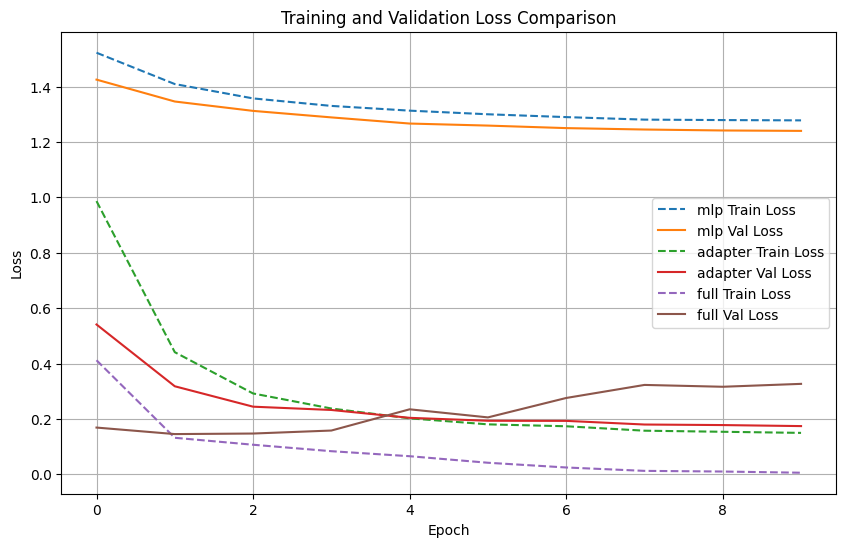

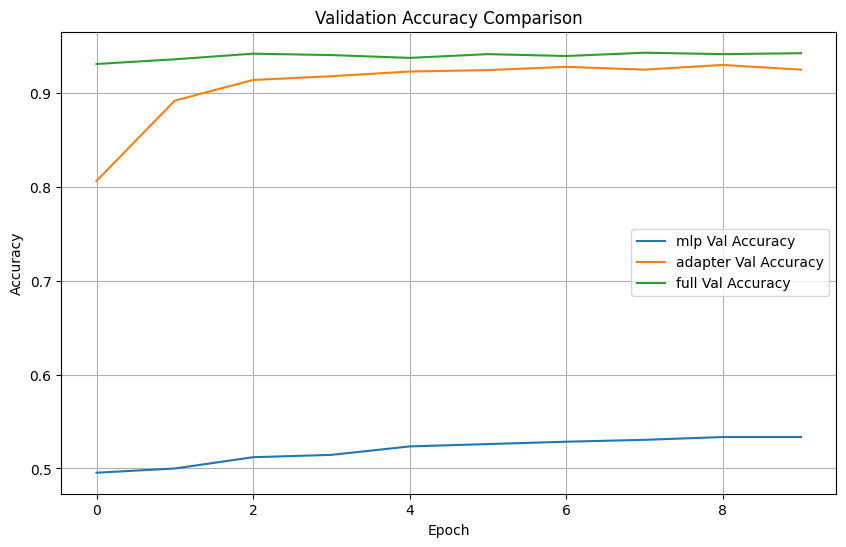

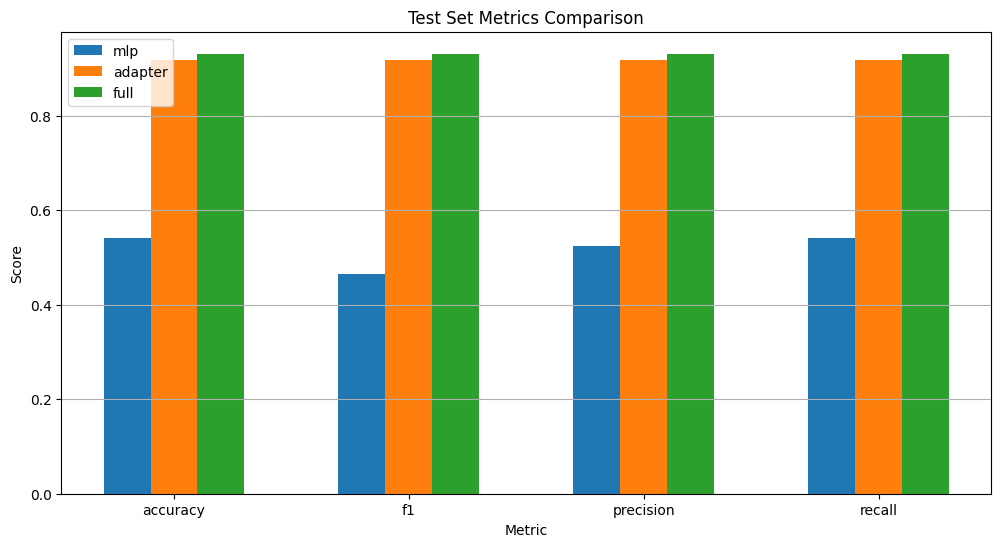

In [9]:
# ===================== Loss Comparison Plot =====================
plt.figure(figsize=(10, 6))
for model_name, res in results.items():
    # Plot training and validation loss for each model
    plt.plot(res["train_loss"], label=f"{model_name} Train Loss", linestyle="--")
    plt.plot(res["val_loss"], label=f"{model_name} Val Loss", linestyle="-")
plt.title("Training and Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ===================== Validation Accuracy Plot =====================
plt.figure(figsize=(10, 6))
for model_name, res in results.items():
    # Plot validation accuracy for each model
    plt.plot(res["val_acc"], label=f"{model_name} Val Accuracy")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ===================== Test Metrics Comparison Bar Chart =====================
metrics = ["accuracy", "f1", "precision", "recall"]
model_names = list(results.keys())
bar_width = 0.2
x = np.arange(len(metrics))

plt.figure(figsize=(12, 6))
for i, model_name in enumerate(model_names):
    # Extract metric values for each model
    values = [results[model_name]["test_metrics"][m] for m in metrics]
    # Offset bars horizontally for visual separation
    plt.bar(x + i * bar_width, values, bar_width, label=model_name)

# Final styling and labeling
plt.title("Test Set Metrics Comparison")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.xticks(x + bar_width * (len(model_names) - 1) / 2, metrics)
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Load the saved full fine-tuning model for inference
save_directory = results["full"]["save_dir"]
loaded_model = BertForSequenceClassification.from_pretrained(save_directory)
loaded_tokenizer = BertTokenizer.from_pretrained(save_directory)
loaded_model.eval()

# Prepare test data for inference
test_dataset = dataset["test"]
test_texts = test_dataset["text"]
true_labels = test_dataset["labels"]
# Select 4 random indices from test set
sample_indices = random.sample(range(len(test_texts)), 4)

# Perform inference on 4 random samples
predictions = []
sample_true_labels = []

print("\n=== Random Sample Inference Results ===\n")
with torch.no_grad():
    for idx in sample_indices:
        text = test_texts[idx]
        true_label = true_labels[idx]
        inputs = loaded_tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        outputs = loaded_model(**inputs)
        pred_label = torch.argmax(outputs.logits, dim=1).item()
        predictions.append(pred_label)
        sample_true_labels.append(true_label.item())  # Convert here too

        emotion = EMOTION_LABELS[pred_label]
        true_emotion = EMOTION_LABELS[true_label.item()]  # <- FIXED
        print(f"Text: {text}")
        print(f"True Emotion: {true_emotion}")
        print(f"Predicted Emotion: {emotion}\n")

# Evaluate results on these 4 samples
inference_report = classification_report(sample_true_labels, predictions, digits=4, zero_division=0)
print("Sample Classification Report:")
print(inference_report)
inference_metrics = {
    "accuracy": accuracy_score(sample_true_labels, predictions),
    "f1": f1_score(sample_true_labels, predictions, average="weighted", zero_division=0),
    "recall": recall_score(sample_true_labels, predictions, average="weighted", zero_division=0),
    "precision": precision_score(sample_true_labels, predictions, average="weighted", zero_division=0)
}
print("Sample Inference Metrics:", inference_metrics)


In [ ]:
=== Random Sample Inference Results ===

Text: i feel reassured that the county government in my county takes the murder of an illegal immigrant in a back alley seriously enough to prosecute someone years later
True Emotion: joy
Predicted Emotion: joy

Text: i feel a little stunned but can t imagine what the folks who were working in the studio up until this morning are feeling
True Emotion: surprise
Predicted Emotion: surprise

Text: i feel so embarrassed
True Emotion: sadness
Predicted Emotion: sadness

Text: im enjoying my solitary confinement at home i rarely feel lonely
True Emotion: sadness
Predicted Emotion: sadness

Sample Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         1
           5     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         4
   macro avg     1.0000    1.0000    1.0000         4
weighted avg     1.0000    1.0000    1.0000         4

Sample Inference Metrics: {'accuracy': 1.0, 'f1': 1.0, 'recall': 1.0, 'precision': 1.0}
